In [131]:
import pandas as pd
import numpy as np
import urllib.request
from zipfile import ZipFile
from re import compile
from pathlib import Path
from shutil import rmtree
deis_data = Path('deis_data')
deis_data.mkdir(parents=True, exist_ok=True)

def get_deis_death_url():
    datapattern = compile('http.*DEFUNCIONES_FUENTE_DEIS_2016_2021.*zip')
    with urllib.request.urlopen('https://deis.minsal.cl/wp-admin/admin-ajax.php?action=wp_ajax_ninja_tables_public_action&table_id=2889&target_action=get-all-data&default_sorting=manual_sort') as f:
        return datapattern.search(f.read().decode().replace(',','\n')).group().replace('\\', '')

def get_csv_deis():
    url = get_deis_death_url()
    urllib.request.urlretrieve(url, 'deis_data/' + url.split('/')[-1])
    with ZipFile('deis_data/' + url.split('/')[-1], 'r') as zip_ref:
        zip_ref.extractall('deis_data')
    return url.split('/')[-1][:-3]
def annos(row):
    edad = row['EDAD_CANT']
    tipo = row['EDAD_TIPO']
    if tipo == 1:
        return edad
    elif tipo == 2:
        return edad/12
    elif tipo == 3:
        return edad/365
    elif tipo == 4:
        return edad/365*24
    else:
        return np.nan
deis_csv = 'deis_data/' + get_csv_deis() + 'csv'

# INE - Proyección base 2017
piramide = {
    '<=19': 4_988_470,
    '20-29': 3_046_000,
    '30-39': 3_120_583,
    '40-49': 2_658_453,
    '50-59': 2_392_614,
    '60-69': 1_857_879,
    '70-79': 1_046_294,
    '>=80': 568_070,
}
columnas = ['ANO_DEF', 'FECHA_DEF', 'GLOSA_SEXO', 'EDAD_TIPO', 'EDAD_CANT', 'CODIGO_COMUNA_RESIDENCIA', 'GLOSA_COMUNA_RESIDENCIA', 'GLOSA_REG_RES', 'DIAG1', 'CAPITULO_DIAG1', 'GLOSA_CAPITULO_DIAG1', 'CODIGO_GRUPO_DIAG1', 'GLOSA_GRUPO_DIAG1', 'CODIGO_CATEGORIA_DIAG1', 'GLOSA_CATEGORIA_DIAG1', 'CODIGO_SUBCATEGORIA_DIAG1', 'GLOSA_SUBCATEGORIA_DIAG1', 'DIAG2', 'CAPITULO_DIAG2', 'GLOSA_CAPITULO_DIAG2', 'CODIGO_GRUPO_DIAG2', 'GLOSA_GRUPO_DIAG2', 'CODIGO_CATEGORIA_DIAG2', 'GLOSA_CATEGORIA_DIAG2', 'CODIGO_SUBCATEGORIA_DIAG2', 'GLOSA_SUBCATEGORIA_DIAG2']
deis = pd.read_csv(deis_csv, sep=';', parse_dates=[1], header=None, names=columnas, index_col=False)
deis.set_index(['FECHA_DEF'], inplace=True)
deis.sort_index(inplace=True)
# CODIGO_CATEGORIA_DIAG1 U07 > covid19
rmtree(deis_data)
deis['EDAD_ANOS'] = deis.apply(annos, axis = 1)
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 999]
bins_10s = [0, 10, 20, 30, 40, 50, 60, 70, 80, 999]
labels = ['00-04', '05-09', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
labels_10s = ['00-09', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
deis['agerange'] = pd.cut(deis.EDAD_ANOS, bins, labels=labels, include_lowest=True, right=False)
deis['agerange_10s'] = pd.cut(deis.EDAD_ANOS, bins_10s, labels=labels_10s, include_lowest=True, right=False)
# deis_gruped = pd.pivot_table(deis.loc[(deis['CODIGO_CATEGORIA_DIAG1'] == 'U07')], values=['EDAD_CANT'], index=['FECHA_DEF'],
#                     columns=['agerange'], aggfunc='count')['EDAD_CANT']
# deis_gruped = deis_gruped.resample('D').asfreq().fillna(0)
# deis_gruped
defunciones_deis_genero_edad = pd.pivot_table(deis.loc[(deis['CODIGO_CATEGORIA_DIAG1'] == 'U07')], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange'], aggfunc='count')['EDAD_CANT']
defunciones_deis_genero_edad.columns.names = ['Sexo', 'Edad']
defunciones_deis_genero_edad.index.name = 'Fecha'
defunciones_deis_genero_edad = defunciones_deis_genero_edad.asfreq('D').fillna(0)

defunciones_deis_genero_edad_10s = pd.pivot_table(deis.loc[(deis['CODIGO_CATEGORIA_DIAG1'] == 'U07')], values=['EDAD_CANT'], index=['FECHA_DEF'],
                    columns=['GLOSA_SEXO', 'agerange_10s'], aggfunc='count')['EDAD_CANT']
defunciones_deis_genero_edad_10s.columns.names = ['Sexo', 'Edad']
defunciones_deis_genero_edad_10s.index.name = 'Fecha'
defunciones_deis_genero_edad_10s = defunciones_deis_genero_edad_10s.asfreq('D').fillna(0)

In [134]:
defunciones_deis_genero_edad_10s.sum()

Sexo    Edad 
Hombre  00-09      32.0
        10-19      31.0
        20-29     151.0
        30-39     480.0
        40-49    1106.0
        50-59    2799.0
        60-69    5045.0
        70-79    6405.0
        80+      6708.0
Mujer   00-09      36.0
        10-19      38.0
        20-29     118.0
        30-39     263.0
        40-49     584.0
        50-59    1511.0
        60-69    3032.0
        70-79    4480.0
        80+      7636.0
dtype: float64

<AxesSubplot:xlabel='FECHA_DEF'>

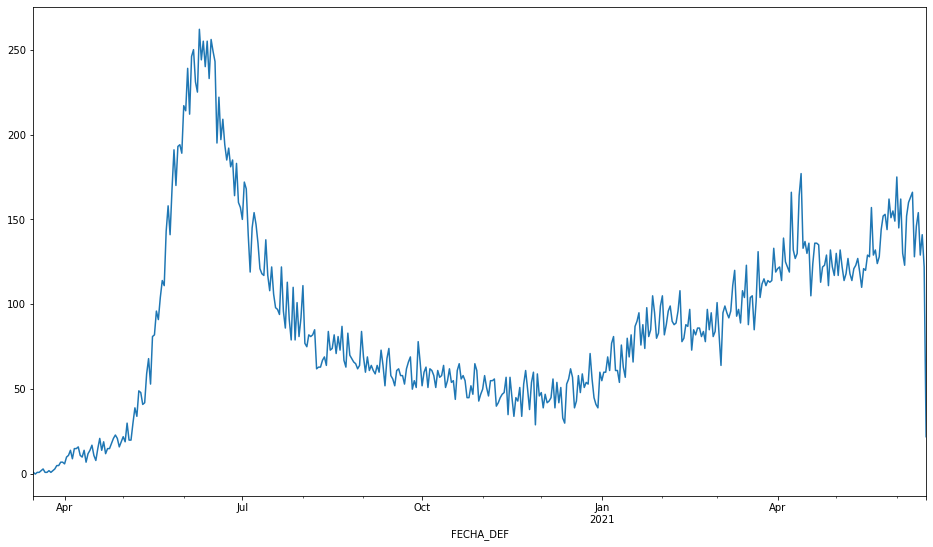

In [16]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# px.line(deis_gruped)
deis_gruped.sum(axis=1).plot(figsize=(16,9))

In [185]:
casos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto16/CasosGeneroEtario_std.csv')
tr_edad = {
    '00 - 04 años': '00-04',
    '05 - 09 años': '05-09',
    '10 - 14 años': '10-14',
    '15 - 19 años': '15-19',
    '20 - 24 años': '20-24',
    '25 - 29 años': '25-29',
    '30 - 34 años': '30-34',
    '35 - 39 años': '35-39',
    '40 - 44 años': '40-44',
    '45 - 49 años': '45-49',
    '50 - 54 años': '50-54',
    '55 - 59 años': '55-59',
    '60 - 64 años': '60-64',
    '65 - 69 años': '65-69',
    '70 - 74 años': '70-74',
    '75 - 79 años': '75-79',
    '80 y más años': '80+'
}
tr_sex ={
    'M': 'Hombre',
    'F': 'Mujer'
}
casos['Grupo de edad'].replace(tr_edad, inplace=True)
casos['Sexo'].replace(tr_sex, inplace=True)
casos['Fecha'] = pd.to_datetime(casos['Fecha'])
casos_genero_edad = pd.pivot_table(casos, values=['Casos confirmados'], index=['Fecha'],
                    columns=['Sexo', 'Grupo de edad'])['Casos confirmados']
# hay un dia que no hubieron nuevos casos, borrando
casos_genero_edad = casos_genero_edad.drop(pd.Timestamp('2020-10-02'))
casos_genero_edad = casos_genero_edad.resample('D').interpolate('quadratic')
casos_genero_edad = casos_genero_edad.diff().fillna(0)

casos_genero_edad.columns.names = ['Sexo', 'Edad']
# casos_genero_edad.index.name = 'Fecha'
casos_genero_edad_10s = casos_genero_edad.copy()
i = 0
for sex in tr_sex.values():
    for ages in labels_10s:
        if ages == '80+':
#             casos_genero_edad_10s[sex, ages] = casos_genero_edad_10s[sex]['80+']
            continue
#         print(casos_genero_edad_10s[sex].columns[i:i+2])
#         print(casos_genero_edad_10s[sex][casos_genero_edad_10s[sex].columns[i:i+2]].sum())
        casos_genero_edad_10s[sex, ages] = casos_genero_edad_10s[sex][casos_genero_edad_10s[sex].columns[i:i+2]].sum(axis=1)
        i += 2
    i = 0
casos_genero_edad_10s.drop(columns=list(tr_edad.values())[:-1], inplace=True, level=1)
casos_genero_edad_10s = casos_genero_edad_10s.sort_index(axis=1)
casos_genero_edad.sum()

Sexo    Edad 
Hombre  00-04     21302.0
        05-09     23085.0
        10-14     29674.0
        15-19     45267.0
        20-24     80364.0
        25-29    106473.0
        30-34    106654.0
        35-39     86957.0
        40-44     72740.0
        45-49     69031.0
        50-54     63321.0
        55-59     58779.0
        60-64     43960.0
        65-69     28331.0
        70-74     19549.0
        75-79     13626.0
        80+       15955.0
Mujer   00-04     19265.0
        05-09     22218.0
        10-14     31228.0
        15-19     50960.0
        20-24     85024.0
        25-29    107228.0
        30-34    101667.0
        35-39     82143.0
        40-44     70519.0
        45-49     69203.0
        50-54     64531.0
        55-59     59057.0
        60-64     43249.0
        65-69     28728.0
        70-74     20912.0
        75-79     15598.0
        80+       24490.0
dtype: float64

In [186]:
casos_genero_edad_10s

Sexo            Hombre                                                  \
Edad             00-09       10-19       20-29       30-39       40-49   
Fecha                                                                    
2020-03-25    0.000000    0.000000    0.000000    0.000000    0.000000   
2020-03-26    1.000000    2.000000   21.000000   32.000000   17.000000   
2020-03-27    0.000000    4.000000   15.000000   19.000000   25.000000   
2020-03-28    2.000000    5.000000   24.000000   45.000000   32.000000   
2020-03-29    0.000000    1.000000   13.000000   16.000000   24.000000   
...                ...         ...         ...         ...         ...   
2021-06-14  254.952972  478.438754  938.508809  849.979945  564.906440   
2021-06-15  249.671783  455.963253  872.505285  807.987967  542.743864   
2021-06-16  244.390594  433.487751  806.501762  765.995989  520.581288   
2021-06-17  239.109406  411.012249  740.498238  724.004011  498.418712   
2021-06-18  233.828217  388.536747  674.494715  682.012033  476.256136   

Sexo                                                            Mujer  \
Edad             50-59       60-69       70-79        80+       00-09   
Fecha                                                                   
2020-03-25    0.000000    0.000000    0.000000   0.000000    0.000000   
2020-03-26   21.000000   12.000000    5.000000   3.000000    2.000000   
2020-03-27   18.000000   10.000000    3.000000   0.000000    0.000000   
2020-03-28   33.000000   12.000000    6.000000   4.000000    3.000000   
2020-03-29   13.000000   20.000000    4.000000   1.000000    4.000000   
...                ...         ...         ...        ...         ...   
2021-06-14  417.124234  312.009051  154.953793  73.240244  228.888178   
2021-06-15  410.674540  303.805430  151.472276  69.644146  217.832907   
2021-06-16  404.224847  295.601810  147.990759  66.048049  206.777636   
2021-06-17  397.775153  287.398190  144.509241  62.451951  195.722364   
2021-06-18  391.325460  279.194570  141.027724  58.855854  184.667093   

Sexo                                                                    \
Edad             10-19       20-29       30-39       40-49       50-59   
Fecha                                                                    
2020-03-25    0.000000    0.000000    0.000000    0.000000    0.000000   
2020-03-26    3.000000   19.000000   34.000000   31.000000   22.000000   
2020-03-27    3.000000   18.000000   23.000000   17.000000   10.000000   
2020-03-28    3.000000   24.000000   30.000000   15.000000   28.000000   
2020-03-29    3.000000   15.000000   22.000000   26.000000    8.000000   
...                ...         ...         ...         ...         ...   
2021-06-14  498.596458  932.730741  853.355211  597.955530  457.921067   
2021-06-15  481.057875  889.738445  812.313127  576.573318  452.152640   
2021-06-16  463.519292  846.746148  771.271042  555.191106  446.384213   
2021-06-17  445.980708  803.753852  730.228958  533.808894  440.615787   
2021-06-18  428.442125  760.761555  689.186873  512.426682  434.847360   

Sexo                                           
Edad            60-69       70-79         80+  
Fecha                                          
2020-03-25    0.00000    0.000000    0.000000  
2020-03-26   10.00000    5.000000    0.000000  
2020-03-27   11.00000    5.000000    1.000000  
2020-03-28   14.00000    5.000000    4.000000  
2020-03-29    7.00000    4.000000    2.000000  
...               ...         ...         ...  
2021-06-14  328.30090  175.355116  102.920154  
2021-06-15  316.18054  165.913070  105.952092  
2021-06-16  304.06018  156.471023  108.984031  
2021-06-17  291.93982  147.028977  112.015969  
2021-06-18  279.81946  137.586930  115.047908  

[451 rows x 18 columns]

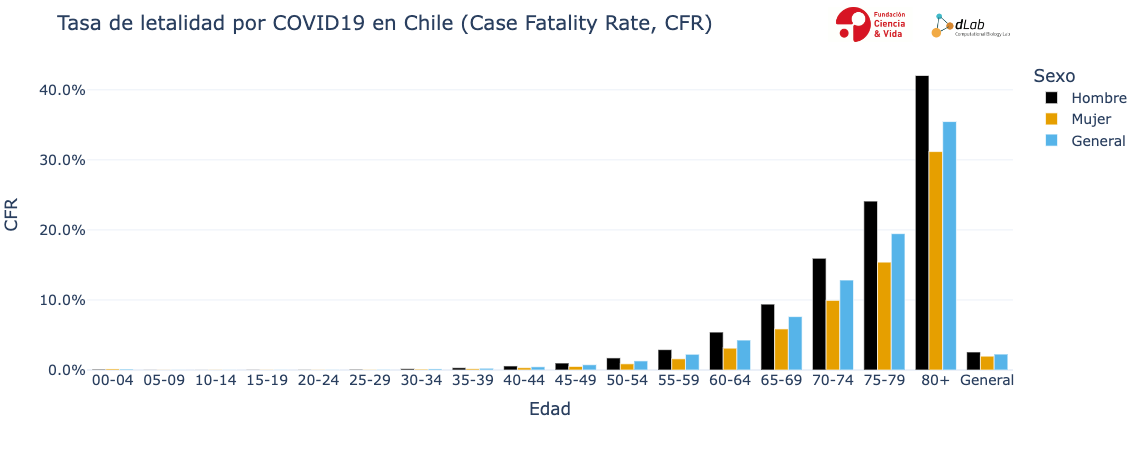

In [206]:
defunciones_deis_edad = defunciones_deis_genero_edad.sum().reset_index().groupby(['Edad']).sum()
casos_edad = casos_genero_edad.sum().reset_index().groupby(['Edad']).sum()
cfr_edad = defunciones_deis_edad/casos_edad
cfr_edad.rename(columns={0: 'CFR'}, inplace=True)
cfr_edad = cfr_edad.reset_index()
overall_ing = 'General'
cfr_edad['Sexo'] = overall_ing

cfr = ((defunciones_deis_genero_edad.sum()/casos_genero_edad.sum()))
cfr.rename('CFR', inplace=True)
cfr = cfr.reset_index()

cfr_total_total = defunciones_deis_genero_edad.sum().sum()/casos_genero_edad.sum().sum()
cfr_total_hombre = defunciones_deis_genero_edad['Hombre'].sum().sum()/casos_genero_edad['Hombre'].sum().sum()
cfr_total_mujer = defunciones_deis_genero_edad['Mujer'].sum().sum()/casos_genero_edad['Mujer'].sum().sum()
cfr = cfr.append({'Sexo': 'Hombre', 'Edad': overall_ing, 'CFR': cfr_total_hombre}, ignore_index=True)
cfr = cfr.append({'Sexo': 'Mujer', 'Edad': overall_ing, 'CFR': cfr_total_mujer}, ignore_index=True)
cfr = cfr.append({'Sexo': overall_ing, 'Edad': overall_ing, 'CFR': cfr_total_total}, ignore_index=True)
cfr = cfr.append(cfr_edad, ignore_index=True)

fig_cfr = px.bar(
    cfr,
    x='Edad',
    y='CFR',
    color='Sexo',
    barmode='group',
    color_discrete_sequence=Wong
)
fig_cfr.update_xaxes(type='category')
fig_cfr.update_layout(hovermode='x')
fig_cfr.update_traces(
    hovertemplate="<br>".join([
#         "Día: %{x}",
        "%{y:.2%}",
    ])
)
fig_cfr.update_layout(
    template='plotly_white',
    yaxis_tickformat = '.1%',
    font=dict(
        size=14,
    ),
    title='Tasa de letalidad por COVID19 en Chile (Case Fatality Rate, CFR)'
)
fig_cfr.add_layout_image(
    dict(
        source="https://i2.wp.com/dlab.cl/wp-content/uploads/2016/08/LogoWebDlab.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
fig_cfr


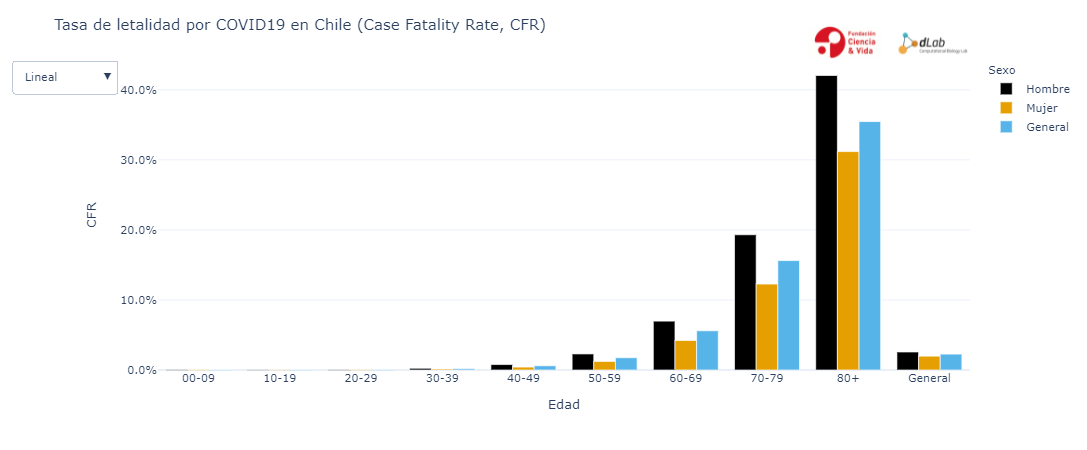

In [191]:
defunciones_deis_edad_10s = defunciones_deis_genero_edad_10s.sum().reset_index().groupby(['Edad']).sum()
casos_edad_10s = casos_genero_edad_10s.sum().reset_index().groupby(['Edad']).sum()
cfr_edad_10s = defunciones_deis_edad_10s/casos_edad_10s
cfr_edad_10s.rename(columns={0: 'CFR'}, inplace=True)
cfr_edad_10s = cfr_edad_10s.reset_index()
overall_ing = 'General'
cfr_edad_10s['Sexo'] = overall_ing

cfr_10s = ((defunciones_deis_genero_edad_10s.sum()/casos_genero_edad_10s.sum()))
cfr_10s.rename('CFR', inplace=True)
cfr_10s = cfr_10s.reset_index()

cfr_total_total_10s = defunciones_deis_genero_edad_10s.sum().sum()/casos_genero_edad_10s.sum().sum()
cfr_total_hombre_10s = defunciones_deis_genero_edad_10s['Hombre'].sum().sum()/casos_genero_edad_10s['Hombre'].sum().sum()
cfr_total_mujer_10s = defunciones_deis_genero_edad_10s['Mujer'].sum().sum()/casos_genero_edad_10s['Mujer'].sum().sum()
cfr_10s = cfr_10s.append({'Sexo': 'Hombre', 'Edad': overall_ing, 'CFR': cfr_total_hombre_10s}, ignore_index=True)
cfr_10s = cfr_10s.append({'Sexo': 'Mujer', 'Edad': overall_ing, 'CFR': cfr_total_mujer_10s}, ignore_index=True)
cfr_10s = cfr_10s.append({'Sexo': overall_ing, 'Edad': overall_ing, 'CFR': cfr_total_total_10s}, ignore_index=True)
cfr_10s = cfr_10s.append(cfr_edad_10s, ignore_index=True)
Wong = ['#000000', '#E69F00', '#56B4E9',
        '#009E73', '#F0E442', '#0072B2',
        '#D55E00', '#CC79A7']

fig_cfr_10s = px.bar(
    cfr_10s,
    x='Edad',
    y='CFR',
    color='Sexo',
    barmode='group',
    color_discrete_sequence=Wong
)
fig_cfr_10s.update_xaxes(type='category')
fig_cfr_10s.update_layout(hovermode='x')
fig_cfr_10s.update_traces(
    hovertemplate="<br>".join([
#         "Día: %{x}",
        "%{y:.2%}",
    ])
)
fig_cfr_10s.update_layout(
    template='plotly_white',
    yaxis_tickformat = '.1%',
    font=dict(
        size=14,
    ),
    title='Tasa de letalidad por COVID19 en Chile (Case Fatality Rate, CFR)'
)
fig_cfr_10s.add_layout_image(
    dict(
        source="https://i2.wp.com/dlab.cl/wp-content/uploads/2016/08/LogoWebDlab.png",
        xref="paper", yref="paper",
        x=1, y=1.0,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
fig_cfr_10s.update_layout(
       updatemenus=[
            dict(
                 buttons=[
                     dict(label="Lineal",  
                          method="relayout", 
                          args=[{"yaxis.type": "linear"}]),
                     dict(label="Logaritmico", 
                          method="relayout", 
                          args=[{"yaxis.type": "log"}]),
                                  ])],
                font=dict(size=11)
            )
fig_cfr_10s


In [192]:
cfr_10s

,Sexo,Edad,CFR
0,Hombre,00-09,0.000721
1,Hombre,10-19,0.000414
2,Hombre,20-29,0.000808
3,Hombre,30-39,0.002479
4,Hombre,40-49,0.007801
5,Hombre,50-59,0.022924
6,Hombre,60-69,0.069787
7,Hombre,70-79,0.193067
8,Hombre,80+,0.420432
9,Mujer,00-09,0.000868
